In [1]:
#!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import os
import cv2
import IPython
import handshape_datasets as hd
import os, sys, getopt
import json
import numpy as np
from tensorflow.python.client import session

In [2]:
from cropper import Cropper

In [3]:
cropper = Cropper(confidence = 0.9)

In [4]:
# if input image is in range 0..1, please first multiply img by 255
# assume image is ndarray of shape [height, width, channels] where channels can be 1, 3 or 4
def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [5]:
dataset_name = 'rwth'
DATASET_PATH = '/develop/data/{}/data'.format(dataset_name)

if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)
data = hd.load(dataset_name, DATASET_PATH)

good_min = 20
good_classes = []
n_unique = len(np.unique(data[1]['y']))
for i in range(n_unique):
    images = data[0][np.equal(i,data[1]['y'])]
    if len(images) >= good_min:
        good_classes = good_classes + [i]

x = data[0][np.in1d(data[1]['y'], good_classes)]
x = [np.expand_dims(i, axis=0) for i in x]
y = data[1]['y'][np.in1d(data[1]['y'], good_classes)]
my_dict = dict(zip(np.unique(y), range(len(np.unique(y)))))
y = np.vectorize(my_dict.get)(y)

In [6]:
images, indexes = cropper.crop_images(x, (64,64))

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f49d6d4b390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


In [7]:
images = np.array(images)

In [8]:
cropped_y = y[indexes]
good_min = 15
good_classes = []
for unique in np.unique(cropped_y):
    if len(np.array(images)[np.equal(unique,cropped_y)]) >= good_min:
        good_classes = good_classes + [unique]


In [9]:
good_classes

[0, 1, 2, 4, 5, 9, 11, 13, 15, 16, 17, 18]

In [10]:
use_cropped = True
if use_cropped:
    new_x = images[np.in1d(cropped_y, good_classes)]
    new_y = cropped_y[np.in1d(cropped_y, good_classes)]
    my_dict = dict(zip(np.unique(new_y), range(len(np.unique(new_y)))))
    new_y = np.vectorize(my_dict.get)(new_y)

else:
    new_x = x[np.in1d(y, good_classes)]
    new_y = y[np.in1d(y, good_classes)]


In [11]:
np.array(x).shape

(3165, 1, 132, 92, 3)

In [12]:
new_x.shape

(903, 64, 64, 3)

In [ ]:
cropped_y = y[indexes]
for unique in np.unique(cropped_y):
    print(len(np.array(images)[np.equal(unique,cropped_y)]))

In [ ]:
cropped_y

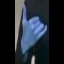

In [29]:
imshow(images[215])

In [44]:
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG(nmixtures=20)
img = images[215].astype('uint8')
img.shape

(64, 64, 3)

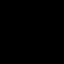

In [45]:
fgmask = fgbg.apply(img)
imshow(fgmask)

In [83]:
indexes

[97,
 194,
 213,
 224,
 227,
 229,
 235,
 237,
 238,
 242,
 243,
 244,
 259,
 266,
 268,
 270,
 271,
 276,
 279,
 282,
 288,
 290,
 292,
 293,
 294,
 300,
 301,
 302,
 303,
 305,
 306,
 307,
 308,
 311,
 312,
 315,
 322,
 324,
 326,
 331,
 332,
 334,
 336,
 339,
 341,
 342,
 343,
 344,
 345,
 346,
 348,
 363,
 366,
 368,
 370,
 372,
 381,
 388,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 432,
 433,
 434,
 435,
 437,
 438,
 439,
 440,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 454,
 455,
 456,
 457,
 460,
 461,
 462,
 463,
 465,
 466,
 468,
 470,
 473,
 477,
 478,
 479,
 480,
 481,
 484,
 488,
 490,
 491,
 492,
 493,
 494,
 496,
 501,
 502,
 509,
 511,
 513,
 516,
 521,
 525,
 526,
 533,
 537,
 539,
 540,
 543,
 544,
 546,
 550,
 551,
 554,
 555,
 556,
 562,
 565,
 570,
 573,
 574,
 575,
 576,
 578,

In [18]:
DIR = "./models/saved_model.pb"

In [19]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.io.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="")
        
    return graph

In [20]:
graph = load_graph(DIR)

In [21]:
graph

In [22]:
for op in graph.get_operations():
    print(op.name)

Const
image_tensor
ToFloat
Preprocessor/map/Shape
Preprocessor/map/strided_slice/stack
Preprocessor/map/strided_slice/stack_1
Preprocessor/map/strided_slice/stack_2
Preprocessor/map/strided_slice
Preprocessor/map/TensorArray
Preprocessor/map/TensorArrayUnstack/Shape
Preprocessor/map/TensorArrayUnstack/strided_slice/stack
Preprocessor/map/TensorArrayUnstack/strided_slice/stack_1
Preprocessor/map/TensorArrayUnstack/strided_slice/stack_2
Preprocessor/map/TensorArrayUnstack/strided_slice
Preprocessor/map/TensorArrayUnstack/range/start
Preprocessor/map/TensorArrayUnstack/range/delta
Preprocessor/map/TensorArrayUnstack/range
Preprocessor/map/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3
Preprocessor/map/Const
Preprocessor/map/TensorArray_1
Preprocessor/map/while/Enter
Preprocessor/map/while/Enter_1
Preprocessor/map/while/Merge
Preprocessor/map/while/Merge_1
Preprocessor/map/while/Less/Enter
Preprocessor/map/while/Less
Preprocessor/map/while/LoopCond
Preprocessor/map/while/Switch

Postprocessor/BatchMultiClassNonMaxSuppression/map/while/add/y
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/add
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/NextIteration
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/NextIteration_1
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/NextIteration_2
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/NextIteration_3
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/NextIteration_5
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/Exit_1
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/Exit_2
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/Exit_3
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/Exit_5
Postprocessor/BatchMultiClassNonMaxSuppression/map/TensorArrayStack/TensorArraySizeV3
Postprocessor/BatchMultiClassNonMaxSuppression/map/TensorArrayStack/range/start
Postprocessor/BatchMultiClassNonMaxSuppression/map/TensorArrayStack/range/delta
Postprocess

In [23]:
dataset_name = 'rwth'
DATASET_PATH = '/develop/data/{}/data'.format(dataset_name)

if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)
data = hd.load(dataset_name, DATASET_PATH)

good_min = 20
good_classes = []
n_unique = len(np.unique(data[1]['y']))
for i in range(n_unique):
    images = data[0][np.equal(i,data[1]['y'])]
    if len(images) >= good_min:
        good_classes = good_classes + [i]

x = data[0][np.in1d(data[1]['y'], good_classes)]
x = [np.expand_dims(i, axis=0) for i in x]
y = data[1]['y'][np.in1d(data[1]['y'], good_classes)]
my_dict = dict(zip(np.unique(y), range(len(np.unique(y)))))
y = np.vectorize(my_dict.get)(y)

inputs = graph.get_tensor_by_name('image_tensor:0')
detection_boxes = graph.get_tensor_by_name('detection_boxes:0')
detection_scores = graph.get_tensor_by_name('detection_scores:0')
detection_classes = graph.get_tensor_by_name('detection_classes:0')
num_detections = graph.get_tensor_by_name('num_detections:0')
outputs = [detection_boxes, detection_scores, detection_classes, num_detections]
all_boxes = []
all_scores = []
all_classes = []
all_num = []

In [24]:
from tensorflow.python.client import session
with session.Session(graph=graph) as sess:
    predict = tf.keras.backend.function(inputs=inputs, outputs=outputs)
    for i in range(len(x)):
        (boxes, scores, classes, num) = predict(x[i])
        np.squeeze(boxes), np.squeeze(scores)
        all_boxes = all_boxes + [boxes.tolist()]
        all_scores = all_scores + [scores.tolist()]
        all_classes = all_classes + [classes.tolist()]
        all_num = all_num + [num.tolist()]
        
    results = {
        "all_boxes": all_boxes,
        "all_scores": all_scores,
        "all_classes": all_classes,
        "all_num": all_num,
    }
    file = open('results.json', 'w')
    file.write(json.dumps(results, indent=2))
    file.close()        

In [25]:
count = 0
ind = 0
for i in range(len(all_scores)):
    score = np.squeeze(all_scores[i])
    if (score.max() > 0.6):
        print(i)
        count += 1
print(count)
print(len(x))
print(len(all_scores))

3
16
60
88
97
107
115
132
136
172
182
183
194
205
213
215
216
224
225
227
228
229
230
235
237
238
242
243
244
251
256
259
266
267
268
270
271
273
275
276
279
281
282
285
288
290
292
293
294
297
298
300
301
302
303
305
306
307
308
310
311
312
314
315
317
320
322
323
324
326
330
331
332
333
334
336
337
338
339
340
341
342
343
344
345
346
348
357
363
366
368
369
370
372
376
379
381
383
387
388
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
432
433
434
435
437
438
439
440
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
459
460
461
462
463
465
466
468
469
470
471
473
475
476
477
478
479
480
481
484
486
487
488
490
491
492
493
494
495
496
501
502
503
506
509
511
513
516
521
523
525
526
530
533
534
537
539
540
543
544
546
550
551
553
554
555
556
559
562
563
565
566
570
573
574
575
576
578
579
581
583
584
589
590
594
599
600
601
602
603
605
606
608
609
614
615
616
617
61

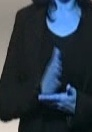

In [69]:
n = 338





img = np.squeeze(x[n])
imshow(img)

In [70]:
np.squeeze(all_scores[n])

array([0.86361951, 0.22386792, 0.08202031, 0.03997609, 0.03608811,
       0.03423265, 0.02618521, 0.01857817, 0.01750886, 0.01739785,
       0.01727378, 0.01615763, 0.01398081, 0.01373735, 0.01252198,
       0.01200181, 0.01197019, 0.01191506, 0.01163086, 0.01148686,
       0.01146734, 0.01138395, 0.0112747 , 0.01108605, 0.01056093,
       0.01055115, 0.01032448, 0.01005825, 0.00961396, 0.00956783,
       0.00947908, 0.00931114, 0.00922367, 0.00910506, 0.00861514,
       0.0085904 , 0.00829527, 0.00797641, 0.00795102, 0.0078229 ,
       0.00773206, 0.00756896, 0.00720069, 0.00709066, 0.00701427,
       0.00692433, 0.00691003, 0.00690639, 0.00687262, 0.00680396,
       0.00658804, 0.00640374, 0.00629365, 0.00612253, 0.00611922,
       0.00599122, 0.00592133, 0.00586691, 0.00580919, 0.00577572,
       0.00552669, 0.00548279, 0.00538239, 0.00533485, 0.00532001,
       0.00528586, 0.00526503, 0.00523087, 0.00522   , 0.00521144,
       0.00518692, 0.00515181, 0.00505486, 0.00502592, 0.00490

In [71]:
img_scores = np.squeeze(all_scores[n])
max_i = img_scores.argmax()
if (img_scores[max_i] > 0.6):
    box = np.squeeze(all_boxes[n])[max_i]
    print(box)

[0.         0.46795619 0.32617921 0.88072443]


In [72]:
shape = img.shape

In [73]:
offset = 0.05
min_y = int(((box[0] - offset) if box[0] > offset else 0)   * shape[0])
min_x = int(((box[1] - offset) if box[1] > offset else 0) * shape[1])
max_y = int(((box[2] + offset) if box[2] + offset < 1 else 1) * shape[0])
max_x = int(((box[3] + offset) if box[3] + offset < 1 else 1) * shape[1])
max_y

49

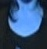

In [74]:
crop_img = img[int(min_y):int(max_y), int(min_x):int(max_x)]
imshow(crop_img)

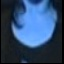

In [75]:
new_width = 64
new_height = 64
height, width, channels = crop_img.shape
ratio = min(new_width/width, new_height/height)
new_x = int(width * ratio)
new_y = int(height * ratio)
resized_img = cv2.resize(crop_img, (int(new_x),int(new_y)))
new_img = np.zeros((new_width, new_height, 3))
x_offset = int((new_width - new_x) / 2)
y_offset = int((new_height - new_y) / 2)
new_img[y_offset:y_offset+new_y, x_offset:x_offset+new_x] = resized_img

imshow(new_img)